# Instruments, data and methods

This section describes the two types of drifters deployed during OTC25, as well as the data and trajectory reconstruction methods used in our analysis.
We first present the design of the MELODI and SPOT drifters.
Next, we introduce the different satellite-derived and drifter datasets (including the preprocessing steps applied when relevant).
Finally, we detail the Lagrangian statistics used to characterize the drift dynamics, the trajectory reconstruction methods implemented, and the metrics employed to evaluate them.

## Drifters deployed during the campaign

@fig-drifters shows a photograph of all drifter types deployed during the campaign, with the exception of the Sofar Spotter. At the time of writing, only eOdyn MELODI and IGE SPOT data are available, and we therefore focus on these two types. However, it should be noted that 16 OpenMetBuoy, 4 CLS MARGE-T II, and 1 Sofar Spotter buoy were also deployed. Including these additional drifters would strengthen our analysis, as we will discuss in @sec-disc.

![Types of drifters deployed during the OTC25 campaign between Tromsø and Nice. There was also a Sofar drifter not shown in the picture. Photo taken by Joël Marc.](images/drifters.png){#fig-drifters}

### MELODI

The MELODI [@MELODI] is a surface drifter developed by the company eOdyn.
Although we are only interested in the drifter's position, it also measures surface currents, surface temperature and wave parameters.
The position is determined using several satellite constellations, with a sampling frequency of 1 hour.
The drifter uses the Iridium satellite network to transmit its data.
It is powered by four Li-ion 3500 mAh, 3.7 V batteries and a 6 W solar panel, which allows it to operate for at least several months.
Thanks to its low-profile, see @fig-melodi-design, the MELODI drifter is expected to be only weakly affected by wind drift.

![Design of the MELODI drifter](images/melodi-design.png){#fig-melodi-design width=50%}

From Tromsø to Nice, 18 MELODI drifters were deployed in various locations: in the North Sea and its Lofoten eddy, in the North Atlantic (including during a storm event), before and after the Strait of Gibraltar (within the Alboran eddy), and in the western Mediterranean Sea.
This can be seen in @fig-drifter-deployments.

In [27]:
# Figure styling
from matplotlib import rc
import matplotlib as mpl
fs = 10
rc('lines',  markersize=10)
rc("legend", fontsize=fs)
rc("axes", labelsize=fs)
rc("xtick", labelsize=fs)
rc("ytick", labelsize=fs)
rc("lines", linewidth=1.5)

mpl.rcParams['font.family'] = ['serif']
mpl.rcParams['font.serif'] = ['Times New Roman']+ mpl.rcParams['font.serif']
mpl.rcParams["mathtext.fontset"] = "stix"

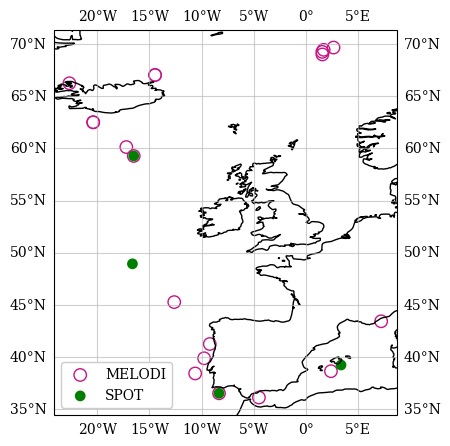

In [30]:
#| label: fig-drifter-deployments
#| fig-cap: "MELODI and SPOT drifter deployments during the OTC25 campaign."
#| out-width: 70%

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd


deployments = pd.read_csv("../data/drifters/deploy_time.csv", parse_dates=["deploy_time"], delimiter=" ")
deployments = deployments[deployments["type"].isin(["MELODI", "SPOT"])]
deployments = deployments.drop_duplicates(subset=["deploy_time", "lat", "lon"], keep="first")
deployments["lat"] = deployments["lat"].astype(float)
deployments["lon"] = deployments["lon"].astype(float)

style_map = {
    "MELODI": {"facecolors": "none", "edgecolors": "mediumvioletred", "marker": "o", "s": 80, "label": "MELODI"},
    "SPOT": {"facecolors": "green", "edgecolors": "none", "marker": "o", "s": 60, "label": "SPOT"},
}

fig, ax = plt.subplots(
    figsize=(5, 5),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

for t, style in style_map.items():
    subset = deployments[deployments["type"] == t]
    ax.scatter(
        subset["lon"], subset["lat"],
        transform=ccrs.PlateCarree(),
        **style
    )

ax.legend(loc="lower left", framealpha=1)
#ax.legend(loc='center left', bbox_to_anchor=(1.15, 0.5))

ax.gridlines(alpha=0.6, draw_labels=True)
ax.coastlines()

plt.show()

### SPOT

The SPOT [@SPOT] is a home-made surface drifter designed and developed at Institut des Géosciences de l'Environnement (IGE).
Its design is very simple, see @fig-spot-design: a weighted waterproof jar containing a GPS tracer powered by external batteries.
The GPS tracer is a SPOT Trace, which uses the Globalstar satellite network to transmit its position every 30 minutes.
External batteries (4 LR20 alkaline 1.5V 13Ah) allow the drifter to operate for up to 6 months and counting at the time of writing.

![Design of the SPOT drifter](images/spot-design.png){#fig-spot-design width=75%}

During the first deployments we noticed that the SPOT drifters exhibited an orbital motion around their vertical axis and we suspected that it was the cause for the observed effective sampling frequency being larger than the nominal 30 minutes (see @fig-spot-sampling-frequency).
To mitigate this motion we designed a dynamic anchor attached to the bottom of the drifter.
Being at sea we had to reuse material available aboard the ship: old sails and steel wire ropes, as visible in @fig-spot-anchor.

![SPOT drifter with a dynamic anchor](images/IMG_0538.jpeg){#fig-spot-anchor width=70%}

The last five drifters deployed in the Mediterranean Sea were equipped with this anchor.
Using the drifter data presented in @sec-data-drif-traj it seems that the anchor was effective in improving the effective sampling frequency, as shown in the left panel of @fig-spot-sampling-frequency.
However, the right panel of @fig-spot-sampling-frequency indicates that, among the drifters deployed in the Mediterranean Sea, drifter #19 stopped emitting very shortly after deployment for an unknown reason, while drifters #16 and #18 beached soon after deployment, leaving only drifters #17 and #20 active for more than a month.
In addition, the Mediterranean Sea is known for its quieter sea state compared to the North Atlantic and the Bay of Biscay, which could explain the improved effective sampling resolution.
Further analysis is therefore required to confirm whether the drogue was indeed effective.

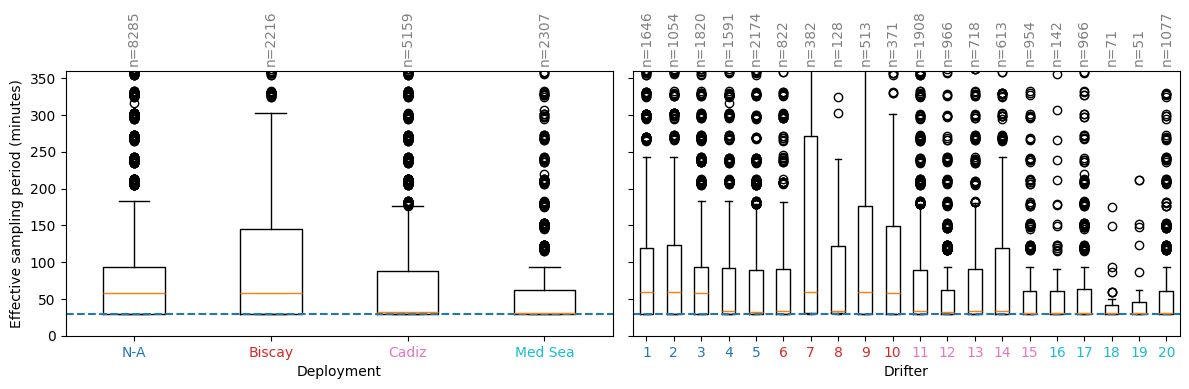

In [60]:
#| label: fig-spot-sampling-frequency
#| fig-cap: "SPOT drifters effective sampling period. The dashed blue line indicates the nominal sampling period of 30 minutes."

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


base_dir = "../data/drifters"
l1_dir = f"{base_dir}/l0"
df = pd.read_parquet(os.path.join(l1_dir, "spot_l0_df.parquet"))
deploy_times = df["deploy_time"].drop_duplicates().sort_values()

sampling_periods_per_drifter = []
deployment_idx = []
sampling_periods_per_deployment = []
for deploy_idx, deploy_time in enumerate(deploy_times, start=1):
    subset = df[df["deploy_time"] == deploy_time]
    dt_deploy = subset["dt"].dropna().to_numpy() / 60
    dt_deploy = dt_deploy[dt_deploy >= 30]
    sampling_periods_per_deployment.append(dt_deploy)
    for drifter_id in subset["drifter_id"].drop_duplicates():
        drifter_subset = subset[subset["drifter_id"] == drifter_id]
        dt = drifter_subset["dt"].dropna().to_numpy() / 60
        dt = dt[dt >= 30]
        sampling_periods_per_drifter.append(dt)
        deployment_idx.append(deploy_idx)

unique_deploys = sorted(set(deployment_idx))
cmap = plt.get_cmap("tab10", len(unique_deploys))
deploy_colors = {dep: cmap(i) for i, dep in enumerate(unique_deploys)}

deployment_indices = np.array(deployment_idx)
middle_indices = {}
for dep in unique_deploys:
    idxs = np.where(deployment_indices == dep)[0]
    if len(idxs) > 0:
        middle_indices[dep] = idxs[len(idxs) // 2]

deployment_labels = ["N-A", "Biscay", "Cadiz", "Med Sea"]

xticklabels = []
for i in range(len(deployment_idx)):
    drifter_num = i + 1
    dep = deployment_idx[i]
    if i == middle_indices[dep]:
        xticklabels.append(f"{drifter_num}\n {deployment_labels[dep-1]}")
    else:
        xticklabels.append(str(drifter_num))

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

ax = axes[0]
ax.boxplot(sampling_periods_per_deployment)
ax.axhline(30, color="tab:blue", linestyle="--")

ax.set_ylim(0, 6 * 60)
ax.set_xlabel("Deployment")
ax.set_ylabel("Effective sampling period (minutes)")
ax.set_xticks(range(1, len(deploy_times) + 1))
ax.set_xticklabels(deployment_labels)

for i in range(len(unique_deploys)):
    ax.get_xticklabels()[i].set_color(cmap(i))

ymin, ymax = ax.get_ylim()
for i, data in enumerate(sampling_periods_per_deployment, start=1):
    n = len(data)
    ax.text(i, ymax * 1.02, f"n={n}", ha="center", va="bottom", rotation=90, color="gray", clip_on=False)

ax = axes[1]
bp = ax.boxplot(sampling_periods_per_drifter)
ax.axhline(30, color="tab:blue", linestyle="--")

ax.set_ylim(0, 6 * 60)
ax.set_xlabel("Drifter")
ax.set_xticks(range(1, len(xticklabels) + 1))
ax.set_xticklabels(range(1, len(xticklabels) + 1))
# ax.set_xticklabels(xticklabels)

for i, dep in enumerate(deployment_idx):
    ax.get_xticklabels()[i].set_color(deploy_colors[dep])

for i, data in enumerate(sampling_periods_per_drifter, start=1):
    n = len(data)
    ax.text(i, ymax * 1.02, f"n={n}", ha="center", va="bottom", rotation=90, color="gray", clip_on=False)

plt.tight_layout()
plt.show()


[S. : Je pense que cette figure n'est pas si simple à interpreter parce que ça donne l'impression que les derniers drifters ont marché super bien, mais en vrai 1 était mort et 2 autres ont pas beaucoup transmis. Cette répresentation prends pas en compte la quantité de drifters qui transmettent et pendant combien de temps ils ont vécu. \
V. : Je suis d'accord, j'ai modifié la figure et le commentaire.]{style="color: red;"}

## Satellite and drifter data

Our analysis requires both maps of geophysical quantities (surface currents, waves, winds) and lagrangian drifter trajectories. 

### Satellite-derived gridded products {#sec-data-gridded-products}

Geophysical quantities of interest are derived from satellite observations, assimilated in physical models of varying complexity.

#### Sea Surface Height
VarDyn is a variational mapping method jointly reconstructing Sea Surface Height (SSH) and Sea Surface Temperature (SST) [@leguillouVarDynDynamicalJointReconstructions2025].
The version used in our analysis assimilates both SWOT KaRin and Nadir altimeters data and produces daily 0.05° $\times$ 0.05° maps.
This dataset provides both SSH and sea surface currents, derived from the SSH field.

#### Sea Surface Wind
Wind acts both directly on the drifter (the leeway) and indirectly through its effect on waves and currents.
We use the wind velocity and stress at the surface from the 0.125° $\times$ 0.125° hourly ECMWF bias corrected product [@SeaSurfaceWind] developed by the Royal Netherlands Meteorological Institute.

#### Sea State
Waves also affect drifter trajectories through the Stokes drift.
We employ the Stokes drift obtained by assimilating significant wave height in the wave model MFWAM, available in the 0.083° $\times$ 0.083° hourly Global Ocean Waves Analysis and Forecast product [@SeaState] developed by Mercator Ocean International.

### Drifter data {#sec-data-drif-traj}

Starting from the raw GPS positions transmitted by the drifters, we perform several preprocessing steps before using them in our analysis.

#### L0 version

The L0 version of the data consists of datasets containing the original timestamps and positions (latitude and longitude) for each drifter, complemented by its deployment date and time.
Each record also includes the time interval between successive measurements.

In [12]:
#| echo: false

import glob
import os
import sys

import pandas as pd

sys.path.append(os.path.abspath("../src"))
from drifters_data import raw_to_l0


def do_raw_to_l0(dataset):
    raw_files = glob.glob(os.path.join(raw_dir, dataset, "*.json"))
    l0_df, l0_ds = raw_to_l0(raw_files, deployment_dates)

    l0_df.to_parquet(os.path.join(l0_dir, f"{dataset}_l0_df.parquet"), index=False)
    l0_ds.to_zarr(os.path.join(l0_dir, f"{dataset}_l0_ds.zarr"), mode="w")


base_dir = "../data/drifters"
raw_dir = f"{base_dir}/raw"
l0_dir = f"{base_dir}/l0"

deployment_dates = pd.read_csv(os.path.join(base_dir, "deploy_time.csv"), delimiter=" ")
deployment_dates["deploy_time"] = pd.to_datetime(deployment_dates["deploy_time"], format="%Y-%m-%dT%H:%M:%SZ", utc=True)

do_raw_to_l0("spot")
do_raw_to_l0("melodi")

#### L1 version

The L1 version of the data is produced by applying the following Quality Control (QC) steps to the L0 dataset:

1. Spurious GPS locations were removed following the procedure described by @elipotGlobalSurfaceDrifter2016,
2. Curated trajectories were divided into segments whenever the time gap between two consecutive timestamps exceeded 6 hours,
3. Segments shorter than 1 day are discarded.

In [13]:
#| echo: false

import os
import sys

import pandas as pd

sys.path.append(os.path.abspath("../src"))
from drifters_data import l0_to_l1


def do_l0_to_l1(dataset):
    l0_df = pd.read_parquet(os.path.join(l0_dir, f"{dataset}_l0_df.parquet"))
    l1_df, l1_ds = l0_to_l1(l0_df)

    l1_df.to_parquet(os.path.join(l1_dir, f"{dataset}_l1_df.parquet"), index=False)
    l1_ds.to_zarr(os.path.join(l1_dir, f"{dataset}_l1_ds.zarr"), mode="w")

    nobs_l0 = len(l0_df)
    ntraj_l0 = l0_df["drifter_id"].nunique()
    nobs_l1 = len(l1_df)
    ntraj_l1 = len(l1_ds["rows"])

    return nobs_l0, ntraj_l0, nobs_l1, ntraj_l1


base_dir = "../data/drifters"
l0_dir = f"{base_dir}/l0"
l1_dir = f"{base_dir}/l1"

nobs_spot_l0, ntraj_spot_l0, nobs_spot_l1, ntraj_spot_l1 = do_l0_to_l1("spot")
nobs_melodi_l0, ntraj_melodi_l0, nobs_melodi_l1, ntraj_melodi_l1 = do_l0_to_l1("melodi")

As shown in @tbl-qc-numbers, these QC steps result in only a small reduction in the number of MELODI drifter observations.
In contrast, about 20% of the SPOT observations were discarded, primarily due to transmission issues that caused large gaps in the original trajectories and consequently led to many short segments being removed.

In [14]:
#| label: tbl-qc-numbers
#| tbl-cap: Number of observations and segments in L0 and L1 versions for SPOT and MELODI datasets.

from IPython.display import display

import pandas as pd


column_names = pd.DataFrame(
    [
        ["# Observations", "L0"], 
        ["# Observations", "L1"], 
        ["# Segments", "L0"], 
        ["# Segments", "L1"]
    ],
    columns=["Dataset", ""]
)

rows = [
    [nobs_spot_l0, nobs_spot_l1, ntraj_spot_l0, ntraj_spot_l1],
    [nobs_melodi_l0, nobs_melodi_l1, ntraj_melodi_l0, ntraj_melodi_l1]
]

columns = pd.MultiIndex.from_frame(column_names)
index = ["SPOT", "MELODI"]

df = pd.DataFrame(rows, columns=columns, index=index)
display(df)

Dataset # Observations        # Segments     
                    L0     L1         L0   L1
SPOT             24503  19846         20  189
MELODI           47399  46837         19   39

#### L2 version

Trajectories are resampled at a regular time interval of 1 hour using a linear interpolation for the positions and the velocities are then computed using central differences.

In [15]:
#| echo: false

import os
import sys

import pandas as pd

sys.path.append(os.path.abspath("../src"))
from drifters_data import l1_to_l2


def do_l1_to_l2(dataset):
    l1_df = pd.read_parquet(os.path.join(l1_dir, f"{dataset}_l1_df.parquet"))
    l2_df, l2_ds = l1_to_l2(l1_df)

    l2_df.to_parquet(os.path.join(l2_dir, f"{dataset}_l2_df.parquet"), index=False)
    l2_ds.to_zarr(os.path.join(l2_dir, f"{dataset}_l2_ds.zarr"), mode="w")


base_dir = "../data/drifters"
l1_dir = f"{base_dir}/l1"
l2_dir = f"{base_dir}/l2"

do_l1_to_l2("spot")
do_l1_to_l2("melodi")

An example of L0, L1 and L2 trajectories for a SPOT drifter is shown in @fig-drifter-processing.
It can be seen that the L0 trajectory contains some spurious points, which are removed in the L1 and L2 versions.
Holes in the L1 and L2 trajectories correspond to gaps larger than 6 hours in the original data.
Holes are not filled by interpolation in the L2 version as those trajectories are then considered as distinct segments.

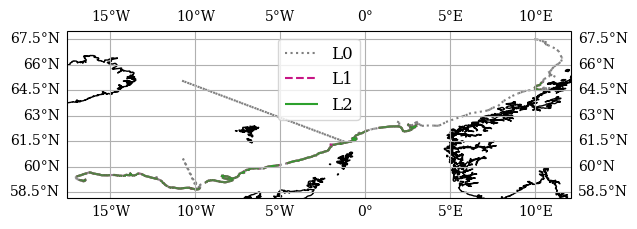

In [27]:
#| label: fig-drifter-processing
#| fig-cap: "SPOT drifter 0-4498291 data (2025-05-12 – 2025-09-16) at different pre-processing levels."
#| out-width: 70%

import os 

import cartopy.crs as ccrs
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def add_lc(subset, style, min_lat, max_lat, min_lon, max_lon):
    lon = subset["lon"].to_numpy()
    lat = subset["lat"].to_numpy()

    segments = np.column_stack([lon[:-1], lat[:-1], lon[1:], lat[1:],]).reshape(-1, 2, 2)

    lc = LineCollection(segments, transform=ccrs.PlateCarree(), **style)
    ax.add_collection(lc)

    if np.min(lat) < min_lat:
        min_lat = np.min(lat)
    if np.max(lat) > max_lat:
        max_lat = np.max(lat)
    if np.min(lon) < min_lon:
        min_lon = np.min(lon)
    if np.max(lon) > max_lon:
        max_lon = np.max(lon)

    return min_lat, max_lat, min_lon, max_lon


base_dir = "../data/drifters"
l0_dir = f"{base_dir}/l0"
l1_dir = f"{base_dir}/l1"
l2_dir = f"{base_dir}/l2"

spot_l0_df = pd.read_parquet(os.path.join(l0_dir, "spot_l0_df.parquet"))
spot_l1_df = pd.read_parquet(os.path.join(l1_dir, "spot_l1_df.parquet"))
spot_l2_df = pd.read_parquet(os.path.join(l2_dir, "spot_l2_df.parquet"))

drifter_id = "0-4498291"

l0_df = spot_l0_df[spot_l0_df["drifter_id"] == drifter_id]
l1_df = spot_l1_df[spot_l1_df["drifter_id"] == drifter_id]
l2_df = spot_l2_df[spot_l2_df["drifter_id"] == drifter_id]

dfs = [l0_df, l1_df, l2_df]

styles = [
    {"linestyle": "dotted", "color": "tab:gray", "label": "L0"},
    {"linestyle": "dashed", "color": "mediumvioletred", "label": "L1"},
    {"linestyle": "solid", "color": "tab:green", "label": "L2"},
]

fig, ax = plt.subplots(
    figsize=(6.5, 5),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

min_lat = np.inf
max_lat = -np.inf
min_lon = np.inf
max_lon = -np.inf

for i in range(len(styles)):
    df = dfs[i]
    style = styles[i]

    if "traj_id" not in df.columns:
        min_lat, max_lat, min_lon, max_lon = add_lc(df, style, min_lat, max_lat, min_lon, max_lon)
    else:
        traj_ids = df["traj_id"].drop_duplicates().sort_values()
        for traj_id in traj_ids:
            subset = df[df["traj_id"] == traj_id]
            min_lat, max_lat, min_lon, max_lon = add_lc(subset, style, min_lat, max_lat, min_lon, max_lon)
            style.pop("label", None)

ax.set_xlim([min_lon - .5, max_lon + .5])
ax.set_ylim([min_lat - .5, max_lat + .5])

ax.legend(loc="upper center")

ax.coastlines()
ax.gridlines(draw_labels=True)

plt.show()

@fig-drifter-traj presents the L2 trajectories of both SPOT and MELODI drifters deployed between Tromsø and Nice during OTC25.

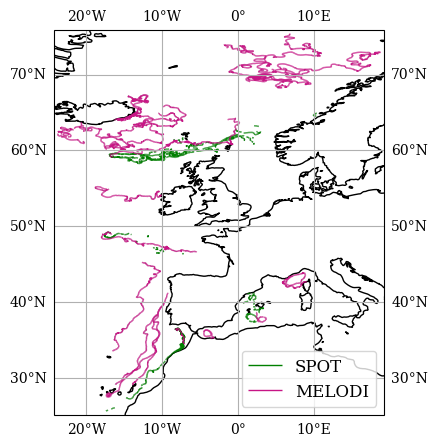

In [ ]:
#| label: fig-drifter-traj
#| fig-cap: "L2 drifters data from the OTC 25 (2025-04-25 – 2025-09-16)."
#| out-width: 70%
import os 

import cartopy.crs as ccrs
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def add_lc(subset, style, min_lat, max_lat, min_lon, max_lon):
    lon = subset["lon"].to_numpy()
    lat = subset["lat"].to_numpy()

    segments = np.column_stack([lon[:-1], lat[:-1], lon[1:], lat[1:],]).reshape(-1, 2, 2)

    lc = LineCollection(segments, transform=ccrs.PlateCarree(), **style)
    ax.add_collection(lc)

    if np.min(lat) < min_lat:
        min_lat = np.min(lat)
    if np.max(lat) > max_lat:
        max_lat = np.max(lat)
    if np.min(lon) < min_lon:
        min_lon = np.min(lon)
    if np.max(lon) > max_lon:
        max_lon = np.max(lon)

    return min_lat, max_lat, min_lon, max_lon


base_dir = "../data/drifters"
l2_dir = f"{base_dir}/l2"

spot_l2_df = pd.read_parquet(os.path.join(l2_dir, "spot_l2_df.parquet"))
melodi_l2_df = pd.read_parquet(os.path.join(l2_dir, "melodi_l2_df.parquet"))

dfs = [spot_l2_df, melodi_l2_df]

styles = [
    {"lw": 1, "color": "green", "label": "SPOT"},
    {"lw": 1, "color": "mediumvioletred", "label": "MELODI"},
]

fig, ax = plt.subplots(
    figsize=(6.5, 5),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

min_lat = np.inf
max_lat = -np.inf
min_lon = np.inf
max_lon = -np.inf

for i in range(len(styles)):
    df = dfs[i]
    style = styles[i]

    traj_ids = df["traj_id"].drop_duplicates().sort_values()
    for traj_id in traj_ids:
        subset = df[df["traj_id"] == traj_id]
        min_lat, max_lat, min_lon, max_lon = add_lc(subset, style, min_lat, max_lat, min_lon, max_lon)
        style.pop("label", None)

ax.set_xlim([min_lon - .5, max_lon + .5])
ax.set_ylim([min_lat - .5, max_lat + .5])

ax.legend(loc="lower right")

ax.coastlines()
ax.gridlines(draw_labels=True)

plt.show()

## Modeling of drifter trajectories {#sec-model-drif-traj}

This section describes the methods used to analyze the drifter trajectories and reconstruct their positions.
We first introduce the trajectory reconstruction methods implemented in our analysis and we detail the metrics employed to evaluate them.
Next, we present the Lagrangian statistics used to characterize the drift dynamics.

### Linear combination {#subsec-linear-combination}

First, the drift is modeled as a simple linear combination of geophysical forcings acting on the object:

$$
\frac{d\mathbf{X}(t)}{dt} = (\mathbf{u}_{cg} + \mathbf{u}_e + \mathbf{u}_s + \beta_w \mathbf{u}_w)(t, \mathbf{X}(t))
$$

where $\mathbf{X}(t)$ is the position of the particle at time $t$, $\mathbf{u}_{cg}$ is the current velocity vector field estimated from *balanced* SSH, $\mathbf{u}_e$ is the wind-induced Ekman current velocity vector field, $\mathbf{u}_s$ is the wave-induced Stokes drift velocity vector field, $\mathbf{u}_w$ is the wind velocity vector field at the sea surface, weighted by $\beta_w$. The notation $( \cdot )(t, \mathbf{X}(t))$ indicates that the linear combination of the velocity vector fields is interpolated in space and time at the particle position.

The geostrophic approximation is the method classically employed in operational products to derive sea surface currents from SSH by solving the equilibrium between the Coriolis (pseudo-)force and the pressure gradient:
$$
f \mathbf{k} \times \mathbf{u}_g = -g \nabla \eta
$$
where $f$ is the Coriolis parameter, $\mathbf{k}$ is the vertical unit vector, $\mathbf{u}_g$ the geostrophic velocity vector, $g$ is the gravitational acceleration and $\eta$ is the SSH.
The geostrophic balance neglects, in particular, the centrifugial acceleration of the flow. This advective term can become significant in intense mesoscale eddies, rings and meanders [@penvenCyclogeostrophicBalanceMozambique2014] or in submesoscale structures [@archerWideswathSatelliteAltimetry2025; @tranchantSWOTRevealsFineScale2025]. Accounting for the advection of momentum leads to the cyclogeostrophic equilibrium:
$$
\mathbf{u}_{cg} - \frac{\mathbf{k}}{f} \wedge (\mathbf{u}_{cg} \cdot \nabla)\mathbf{u}_{cg} =  \mathbf{u}_g
$$
where $\mathbf{u}_{cg}$ is the cyclogeostrophic velocity vector.
Solving the cyclogoeostrophic equation cannot be done analyticaly in the general case [@penvenCyclogeostrophicBalanceMozambique2014]; therefore the VarDyn product uses the cyclogeostrophic inversion method proposed by @bertrandRobustVariationalFramework2025 and implemented in the Python package `jaxparrow` [@bertrandJaxparrow2025].

Following classical Ekman theory [@ekman1905], we estimate the Ekman currents at the sea surface as a function of the wind stress at the sea surface provided by ECMWF:
$$
\mathbf{u}_e = \frac{1}{\rho \sqrt{2 A_z |f|}} \tau e^{i \theta_e}
$$
where $\theta_e = 45 °$ controls the deflection of the wind stress vector $\tau$ (should be multiplied by -1 in the North Emisphere), $\rho$ is the seawater density, and $A_z$ is the vertical eddy viscosity.

The Stokes drift and the wind velocity at the sea surface are directly taken from the observation products as detailed in @sec-data-gridded-products.

#### Parameters estimation 

Our linear combination model has two free parameters that we propose to tune from the drifters data.
The vertical eddy viscosity $A_z$ is linked to the Ekman depth and varies depending on the mixing conditions in the upper ocean. It is expected to range from $10^{-2} \text{ m}^2\text{s}^{-1}$ to $10^{-1}\text{ m}^2 \text{s}^{-1}$ in the open ocean under moderate mixing. As the geometry of the drifter does not enter into consideration here, we calibrated this parameter for all the drifters at the same time.
We use the tuning parameter $\beta_w$ to account for the direct effect of the wind on the drifters motion. Since the response of the drifters to the wind may vary due to their specific designs, we calibrated it separately for the MELODI and SPOT drifters, leading to two distinct parameters $\beta_{w_S}$ for the SPOT design and $\beta_{w_M}$ for the MELODI design.

The drift function of a drifter can therefore by re-written as:
$$
\mathbf{v}_d(t, \mathbf{X}(t) ; A_z, \beta_{w_S}, \beta_{w_M}) = [\mathbf{u}_{cg} + \mathbf{u}_e + \mathbf{u}_s + (\mathbf{1}_{S} \beta_{w_S} + \mathbf{1}_{M} \beta_{w_M}) \mathbf{u}_w](t, \mathbf{X}(t))
$${#eq-lin-comb}
where $\mathbf{1}_{S} = 1$ (resp. $\mathbf{1}_{M} = 1$) if the drifter is a SPOT (resp. MELODI) and $0$ otherwise.

$\widehat{A}_z, \widehat{\beta}_{w_S}, \widehat{\beta}_{w_M}$ are estimated by solving a non-negative-least-square problem between two consecutive drifter observations, provided that the observations are sufficiently close in time:
$$
\widehat{A}_z, \widehat{\beta}_{w_S}, \widehat{\beta}_{w_M} = \underset{A_z, \beta_{w_S}, \beta_{w_M} \geq 0}{\arg\min} \sum_i D(\mathbf{X}_{t_i} + \Delta t_i \mathbf{v}_d(t_i, \mathbf{X}_{t_i} ; \beta_w), \mathbf{X}_{t_{i+1}})^2
$$
where $\mathbf{X}_{t_i}$ is an observed drifter position at time $t_i$ and $\Delta_{t_i} = t_{i+1} - t_i$ is the time interval between observations $\mathbf{X}_{t_i}$ and $\mathbf{X}_{t_{i+1}}$.

### Maxey-Riley framework

The Maxey-Riley equations provide an accurate description of floating object drift, making them a useful model for predicting the trajectories of floaters in ocean environments. This framework takes into account all the forces that contribute to their horizontal movement: the *flow force* exerted on the particle by the fluid, the *added mass force* resulting from the displacement of part of the fluid with the particle, the *lift force*, which occurs when the particle rotates while moving in a (horizontal) shear flow, and the *drag force* due to the viscosity of the fluid. Here we present briefly the theory that leads to the Maxey-Riley framework, following @beron2019building. It is important to keep in mind that, despite its mathematical complexity, it is simply the result of applying Newton's second law:

$$
m_p \ddot{x_p} = F_{\text{flow}} + F_{\text{mass}} + F_{\text{lift}} + F_{\text{drag}} 
$${#eq-newton}

where $m_p$ is the particle mass and $\ddot{x_p}$ its acceleration. 

Let us consider a spherical particle of radius $a$ and density $\rho$ floating in the interface between air and water. The *flow force* is given by

$$
F_{\text{flow}} = \frac{m_f}{m_p}\frac{Dv_f}{Dt},
$$ {#eq-flow-force}

where $m_f$ is the mass of the displaced fluid, $v_f$ is the fluid velocity and $\frac{Dv_f}{Dt} = \frac{\partial v_f}{\partial t} + (\nabla v_f) v_f$ stands for material derivative.

The *added mass force* can be expressed as

$$
F_{\text{mass}} = \frac{\frac{1}{2}m_f}{m_p}\Big(\frac{Dv_f}{Dt} - \dot{v_p}\Big),
$$ {#eq-mass-force}

where $\dot{v_p} = \frac{\partial v_p}{\partial t}$ is the particle acceleration.

The *lift force*, generated by the particle rotation, reads:

$$
F_{\text{lift}} =  \frac{\frac{1}{2}m_f}{m_p} \omega_f (v_f - v_p)^\perp,
$$ {#eq-lift-force}

where $\omega_f$ is the vertical vorticity of the fluid and the operator $^\perp$ indicates a 90° counterclockwise rotation.

Finally, the *drag force* is given by

$$
F_{\text{drag}} = \frac{12\mu_f A_f/l_f}{m_p}(v_f - v_p),
$$ {#eq-drag-force}

where $\mu_f$ is the dynamic fluid viscosity, $A_f = \pi a^2$ is the projected area of the particle and $l_a = 2a$ is its projected length.

In order to adapt this fluid mechanics formulation to geophysical flows, a contribution from the Coriolis force is included in the flow and added mass force. The forces are averaged in the vertical direction over the particle's height, with the integration limits being from $−h$ (immersed depth) to $h_a$ (height above the surface), since the fluid variables take different values in the water region $[−h,0)$ and in the air region $(0, h_a]$. This process gives the explicit form of the Maxey-Riley framework:

$$
\dot{v}_{\text{p}} + \left(f + \frac{1}{2}Ra\right)v_{\text{p}}^\perp + \tau^{-1}v_{\text{p}} = R\frac{Dv}{Dt} + R\left(f + \frac{1}{2}\omega\right)v^\perp + \tau^{-1}u,
$$ {#eq-MR-explicit}

where $f$ is the Coriolis parameter, $R$ is a parameter that depends on the depth $h$ of the submerged spherical cap, $\omega$ is the water vorticity, and $\tau$ accounts for the inertial response time of the medium to the particle. $u$ is defined as

$$
u = (1-\alpha)v + \alpha v_a
$$ {#eq-MR-u}

where $v$ is the water velocity, $v_a$ the air velocity and $\alpha$ can be interpreted as a leeway factor. It should be noted that, contrairly to leeway models, where the wind parameter is chosen *ad hoc*, here $\alpha$ is obtained from geometrical characetristics of the particle and it is not a fit parameter.

The drifters we deployed during the OTC25 campaign were not spheric. This difference is taken into account by a correction factor $0\leq \kappa \leq 1$ that changes the value of $\tau$ and is defined as

$$
\kappa^{-1} = \frac{1}{3} \frac{a_n}{a_v} + \frac{2}{3}\frac{a_s}{a_v},
$$ {#eq-kappa}

where $a_n, a_s$ and $a_v$ are the radi of a sphere of the equivalented projected area, surface area and equivalent volume. For the case of a cylinder (like the MELODI drifter), they can be obtained as

$$
a_n = \sqrt{\frac{2R_D H_D}{\pi}}, \quad a_s = R_D, \quad \text{and} \quad a_v = \sqrt[3]{\frac{3}{4}R_D^2 H_D},
$$ {#eq-K-melodi}

where $R_D$ and $H_D$ are the radius and the height of the cylindric drifter.

It has been shown that rotational effects from Earth are generally negligible when the floating object's dimensions are significantly smaller than approximately 1 km [@wagner2022winds]. Whe can thus neglect the Coriolis effect in our measurements, since our drifters are smaller than 30 cm.

We can do one last approximation under the assumption that the particle is small compared to the caracteristic lengths of the flow (known as *slow manifold approximation*). In this case, the inertial response time is short and the Maxey-Riley framework can be simplified to:

$$
\dot{x_p} = u + \tau u_\tau, \quad \text{with} \quad u_\tau = R  + \frac{1}{3}R \omega v^\perp - \frac{Du}{Dt} - \frac{1}{3}R \omega u^\perp
$${#eq-MR}

where $u$ is given by @eq-MR-u. This framework is a two-dimensional system in $x$ and does not require specification of the initial velocity for resolution. This is the equation we used to model the trajectory of the drifters deployed during the campaign.

### Model evaluation

To evaluate the performance of the trajectory reconstruction methods, we integrate the models over N days using the drifter positions as initial conditions.
We then compare the reconstructed trajectories with the observed drifter trajectories using the following metrics:

- **Separation distance**: the separation distance is the distance $D(\mathbf{X}_{t_i}, \mathbf{Y}_{t_i})$ between the reconstructed final position $\mathbf{X}_T$ and the drifter's final position $\mathbf{Y}_T$. We used the Haversine formula to compute the great-circle distance between two positions, assuming the Earth is a perfect sphere.
- **Liu Index**: the Liu index [@liuEvaluationTrajectoryModeling2011] $s(\mathbf{X}, \mathbf{Y})$ allows comparison of reconstructions across different regimes by normalizing the cumulative separation distance by the cumulative distance effectively traveled by the reference drifter. 
It yields a non-dimensional index, where a value of 0 indicates a perfect match between the reconstructed and observed trajectories, and a value of 1 indicates that the reconstruction diverges from the reference as rapidly as the reference itself moves. 
It is defined as:
$$
s(\mathbf{X}, \mathbf{Y}) = \frac{\sum_{t_i=1}^{T} D(\mathbf{X}_{t_i}, \mathbf{Y}_{t_i})}{\sum_{t_i=1}^{T} \sum_{t_j=1}^{t_i} D(\mathbf{Y}_{t_{j-1}}, \mathbf{Y}_{t_j})}
$$

## Pair dispersion

Spreading of a group of surface drifters can be characterized by the distance $D$ between a pair of drifters and the relative diffusivity $K$, defined as:

$$ 
K(D) = \frac{1}{2}\frac{\partial D^2}{\partial t},
$$ {#eq-diffusivity}

where $t$ stands for the time [@van2015pairwise]. Since we study the motion of floaters at the sea surface, we will use the 2-D Quasi-Geostrophic turbulence theory. [add citations]{style="color: red;"} In this context, the dynamics of the pair separation can be classified in three regimes, depending on the scale of the underlying currents. There are two important length scales: the Rossby deformation radius, that is the distance at which rotational effects become important, and the scale of the eddies present in the flow. 

For separations smaller than the Rossby deformation radius, we expect the pair dispersion $D^2$ to increase exponentially with time and the pair diffusivity to be proportional to $D^2$. This is known as the "exponential regime". If the separation is bigger than the Rossby deformation radius but smaller than the biggest eddies in the flow, the dynamics is known as "Richardson regime" and is expected to scale as $D^2 \propto t^3$. The pair diffusivity is expected to be $K \propto D^{4/3}$. These two regimes are *local*, meaning that their dynamics is governed by eddies of $\mathcal{O}(D)$. For scales larger than the eddies, i.e., for non-local dynamics, we expect a diffusive random walk regime with dispersion scaling linearly with time and $K$ keeping a constant value. In this case, the diffusive character of the dynamics arises because each drifter of the pair is influenced by different, uncorrelated eddies.

We performed four deployments of five SPOT drifters each dedicated to study pair dispersion, as shown in @fig-drifter-deployments. The first deployment was performed on the 12th May on the Atlantic Sea, the second on the 18th May, the third on the 24th May just before crossing Gibraltar Strait, and one last deployment on May 30th at the mediterranean sea.
